In [1]:
from google.colab import drive
import pandas as pd
import os
from io import StringIO
# Monter Google Drive
drive.mount('/content/drive', force_remount= True) #force_remount = True permet d'avoir un fichier mis à jour si modifs sur google drive
df=pd.read_csv('/content/drive/MyDrive/Datascientest/Projet_accidents/Dataset/2019_2023/df_machine_learning.csv')
df.info()
df.gravité_accident.value_counts()

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273226 entries, 0 to 273225
Data columns (total 62 columns):
 #   Column                              Non-Null Count   Dtype 
---  ------                              --------------   ----- 
 0   Num_Acc                             273226 non-null  int64 
 1   jour                                273226 non-null  int64 
 2   mois                                273226 non-null  int64 
 3   an                                  273226 non-null  int64 
 4   hrmn                                273226 non-null  object
 5   dep                                 273226 non-null  object
 6   agg                                 273226 non-null  int64 
 7   int                                 273226 non-null  int64 
 8   atm                                 273226 non-null  object
 9   col                                 273226 non-null  int64 
 10  lat                                 273226 non-null  object
 11  long         

,count
gravité_accident,
2,175525
3,82229
4,15472


In [2]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline as imPipeline  # Utilisation d'un pipeline d'imblearn
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import GridSearchCV

XGBOOST avec l'argument classweight pour gérer le déséquilibre des classes: cela permet de ne pas rajouter de données (contrairement à l'oversampling qui va rajouter des données de la classe minoritaire), sur un dataset qui est déjà très lourd.

Classes uniques avant modification: [2 3 4]
Classes uniques après transformation: [0 1 2]
Poids des classes calculés avec 'balanced' : [0.51906048 0.51906048 0.51906048 ... 1.10680703 1.10680703 1.10680703]


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:44:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy du modèle : 0.63

Rapport de classification :
              precision    recall  f1-score   support

           2       0.84      0.73      0.78     35156
           3       0.50      0.43      0.46     16400
           4       0.19      0.61      0.29      3090

    accuracy                           0.63     54646
   macro avg       0.51      0.59      0.51     54646
weighted avg       0.70      0.63      0.65     54646



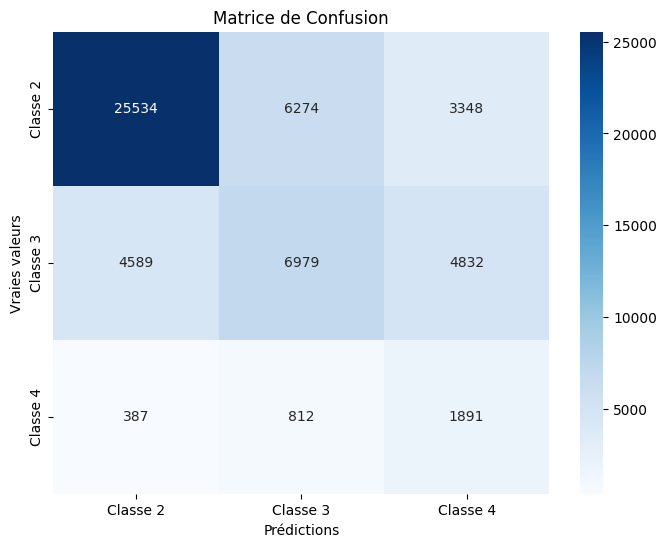

In [ ]:
# Définition de la classe pour la transformation de l'heure
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)  # Assurer que les valeurs sont numériques
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]  # Retourne un array 2D avec sin et cos


# Séparation des variables d'entrée et de sortie
X = df.drop(['lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué', 'blessé_léger',
             'indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']

# Vérification des classes uniques
print("Classes uniques avant modification:", np.unique(y))

# Décalage des labels pour correspondre à l'attente d'XGBoost ([2,3,4] -> [0,1,2])
y = y - 2

# Vérification après transformation
print("Classes uniques après transformation:", np.unique(y))

# Séparation en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Liste des variables catégorielles et cycliques
categorical_features = ['agg', 'atm']  # Variables à encoder
cyclical_features = ['heure']  # Transformation cyclique
passthrough_features = ['nbv', 'vma', 'nationale_departementale_communale', 'autoroute', 'autre_route',
                        'sens_unique', 'bidirectionnel', 'route_seche', 'route_mouillee_enneigee', 'etat_route_autre',
                        'usager_count', 'total_sans_secu', 'total_ceinture', 'total_casque', 'total_secu_enfant',
                        'total_gilet', 'total_airbag', 'total_gants', 'total_gants_airbag', 'total_autre',
                        'place_conducteur', 'pax_AV', 'pax_AR', 'pax_Milieu', 'place_pieton', 'homme', 'femme',
                        '0-17', '18-60', '61-95', 'obstacle_fixe', 'obstacle_mobile', 'aucun_choc', 'choc_AV',
                        'choc_AR', 'choc_cote', 'choc_tonneaux', 'VL_VU', '2roues_3roues_quad', 'PL', 'bus_car',
                        'velo_trott_edp', 'nbr_veh']  # À laisser inchangées

# Appliquer le ColumnTransformer pour transformer les variables
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cyclical', CyclicalFeatures(), cyclical_features)
], remainder='passthrough')

# Calculer les poids des classes (pour gérer le déséquilibre)
class_weights = compute_sample_weight(class_weight='balanced', y=y_train)
print("Poids des classes calculés avec 'balanced' :", class_weights)

# Créer et entraîner le modèle XGBoost
model = XGBClassifier(
    objective='multi:softmax',  # Classification multiclasses
    num_class=3,  # Nombre de classes
    eval_metric='mlogloss',  # Log loss
    use_label_encoder=False,  # Suppression d'un avertissement lié à XGBoost
    random_state=42
)

# Appliquer la transformation de prétraitement sur les données d'entraînement
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Entraîner le modèle avec les poids de classes
model.fit(X_train_transformed, y_train, sample_weight=class_weights)

# Prédictions (on reconvertit les classes en [2,3,4])
y_pred = model.predict(X_test_transformed) + 2

# Évaluation du modèle
accuracy = accuracy_score(y_test + 2, y_pred)  # On ajoute 2 à y_test pour correspondre aux vraies classes
print(f"Accuracy du modèle : {accuracy:.2f}")

# Rapport de classification détaillé
print("\nRapport de classification :")
print(classification_report(y_test + 2, y_pred))

# Visualisation de la matrice de confusion
conf_matrix = confusion_matrix(y_test + 2, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['léger', 'hospitalisé', 'tué'],
            yticklabels=['léger', 'hospitalisé', 'tué'])
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de Confusion')
plt.show()




XGBOOST avec oversampling

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:34:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy du modèle : 0.72

Rapport de classification :
              precision    recall  f1-score   support

           2       0.77      0.89      0.82     35106
           3       0.59      0.46      0.52     16446
           4       0.39      0.14      0.20      3094

    accuracy                           0.72     54646
   macro avg       0.58      0.50      0.51     54646
weighted avg       0.69      0.72      0.70     54646



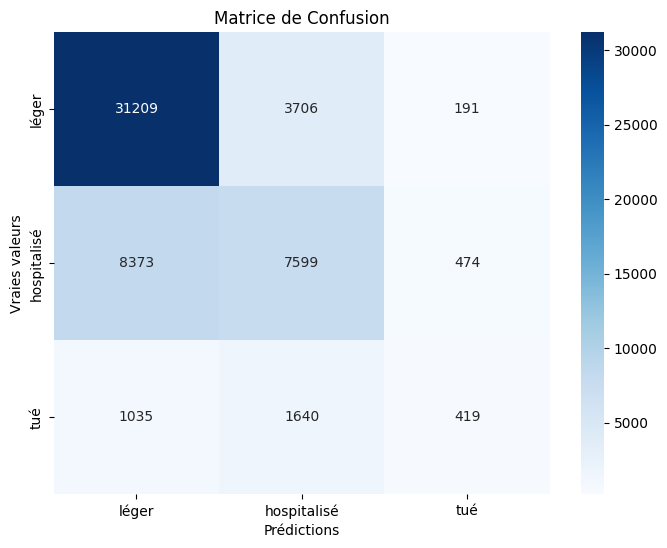

In [3]:
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline

# Définition de la classe pour la transformation de l'heure
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)  # Assurer que les valeurs sont numériques
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]  # Retourne un array 2D avec sin et cos

# Séparation des variables d'entrée et de sortie
X = df.drop(['lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué', 'blessé_léger',
             'indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']

# Décalage des labels pour correspondre à l'attente d'XGBoost ([2,3,4] -> [0,1,2])
y = y - 2

# Séparation en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Liste des variables catégorielles et cycliques
categorical_features = ['agg', 'atm']  # Variables à encoder
cyclical_features = ['heure']  # Transformation cyclique
passthrough_features = ['nbv', 'vma', 'nationale_departementale_communale', 'autoroute', 'autre_route',
                        'sens_unique', 'bidirectionnel', 'route_seche', 'route_mouillee_enneigee', 'etat_route_autre',
                        'usager_count', 'total_sans_secu', 'total_ceinture', 'total_casque', 'total_secu_enfant',
                        'total_gilet', 'total_airbag', 'total_gants', 'total_gants_airbag', 'total_autre',
                        'place_conducteur', 'pax_AV', 'pax_AR', 'pax_Milieu', 'place_pieton', 'homme', 'femme',
                        '0-17', '18-60', '61-95', 'obstacle_fixe', 'obstacle_mobile', 'aucun_choc', 'choc_AV',
                        'choc_AR', 'choc_cote', 'choc_tonneaux', 'VL_VU', '2roues_3roues_quad', 'PL', 'bus_car',
                        'velo_trott_edp', 'nbr_veh']  # À laisser inchangées

# Appliquer le ColumnTransformer pour transformer les variables
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cyclical', CyclicalFeatures(), cyclical_features)
], remainder='passthrough')

# Transformation des données d'entraînement
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Application de SMOTE pour équilibrer les classes
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)

# Création et entraînement du modèle XGBoost
model = XGBClassifier(
    objective='multi:softmax',  # Classification multiclasses
    num_class=3,  # Nombre de classes
    eval_metric='mlogloss',  # Log loss
    use_label_encoder=False,  # Suppression d'un avertissement lié à XGBoost
    random_state=42
)
model.fit(X_train_resampled, y_train_resampled)

# Prédictions (on reconvertit les classes en [2,3,4])
y_pred = model.predict(X_test_transformed) + 2

# Évaluation du modèle
print(f"Accuracy du modèle : {accuracy_score(y_test + 2, y_pred):.2f}")
print("\nRapport de classification :")
print(classification_report(y_test + 2, y_pred))

# Visualisation de la matrice de confusion
conf_matrix = confusion_matrix(y_test + 2, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['léger', 'hospitalisé', 'tué'],
            yticklabels=['léger', 'hospitalisé', 'tué'])
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de Confusion')
plt.show()


Optimisation des hyperparamètres et classe weight: on pourrait ajouter beaucoup d'hyperparamètres mais ça plante systématiquement

Fitting 3 folds for each of 27 candidates, totalling 81 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:46:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Meilleurs paramètres trouvés :  {'classifier__max_depth': 6, 'classifier__n_estimators': 100, 'classifier__scale_pos_weight': 1}
Meilleure précision sur l'ensemble d'entraînement :  0.7177006130478544

Rapport de classification :
              precision    recall  f1-score   support

           0       0.77      0.89      0.83     35106
           1       0.58      0.49      0.53     16446
           2       0.46      0.07      0.12      3094

    accuracy                           0.72     54646
   macro avg       0.60      0.48      0.49     54646
weighted avg       0.70      0.72      0.70     54646



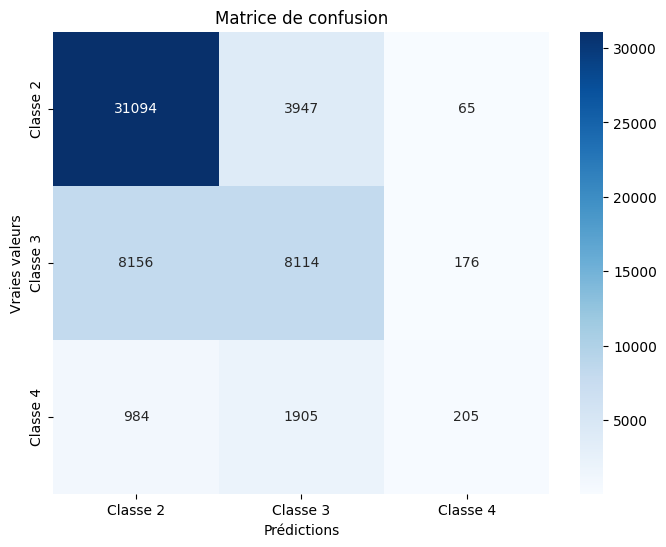

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Définition de la transformation cyclique pour les variables horaires
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]

# Séparation des variables d'entrée et de sortie
X = df.drop(['lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué', 'blessé_léger',
             'indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']

# Décalage des labels pour correspondre à l'attente d'XGBoost ([2,3,4] -> [0,1,2])
y = y - 2

# Séparation en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Liste des variables catégorielles et numériques
categorical_features = ['agg', 'atm']
cyclical_features = ['heure']
numerical_features = ['nbv', 'vma', 'nationale_departementale_communale', 'autoroute', 'autre_route',
                      'sens_unique', 'bidirectionnel', 'route_seche', 'route_mouillee_enneigee', 'etat_route_autre',
                      'usager_count', 'total_sans_secu', 'total_ceinture', 'total_casque', 'total_secu_enfant',
                      'total_gilet', 'total_airbag', 'total_gants', 'total_gants_airbag', 'total_autre',
                      'place_conducteur', 'pax_AV', 'pax_AR', 'pax_Milieu', 'place_pieton', 'homme', 'femme',
                      '0-17', '18-60', '61-95', 'obstacle_fixe', 'obstacle_mobile', 'aucun_choc', 'choc_AV',
                      'choc_AR', 'choc_cote', 'choc_tonneaux', 'VL_VU', '2roues_3roues_quad', 'PL', 'bus_car',
                      'velo_trott_edp', 'nbr_veh']

# Pipeline de transformation
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('cyclical', CyclicalFeatures(), cyclical_features),
        ('num', StandardScaler(), numerical_features)
    ],
    remainder='passthrough'  # Conserve les autres variables sans modification
)

# Construction du pipeline avec XGBoost
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', random_state=42))
])

# Définition de la grille d'hyperparamètres pour GridSearchCV
param_grid = {

    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 6, 10],
    'classifier__scale_pos_weight': [1, 2, 5]  # Gestion du déséquilibre des classes
}

# Recherche des meilleurs paramètres avec GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)

# Entraîner le modèle avec la recherche en grille
grid_search.fit(X_train, y_train)

# Meilleurs paramètres et précision
print("Meilleurs paramètres trouvés : ", grid_search.best_params_)
print("Meilleure précision sur l'ensemble d'entraînement : ", grid_search.best_score_)

# Prédictions sur l'ensemble de test
y_pred = grid_search.predict(X_test)

# Rapport de classification
print("\nRapport de classification :")
print(classification_report(y_test, y_pred))

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Classe 2', 'Classe 3', 'Classe 4'], yticklabels=['Classe 2', 'Classe 3', 'Classe 4'])
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de confusion')
plt.show()



XGBOOST Avec scoring personnalisé pour optimier le F1_score de la classe 1

Fitting 3 folds for each of 27 candidates, totalling 81 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:11:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Meilleurs hyperparamètres : {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
F1-score de la classe cible (accidents graves) sur test : 0.5241


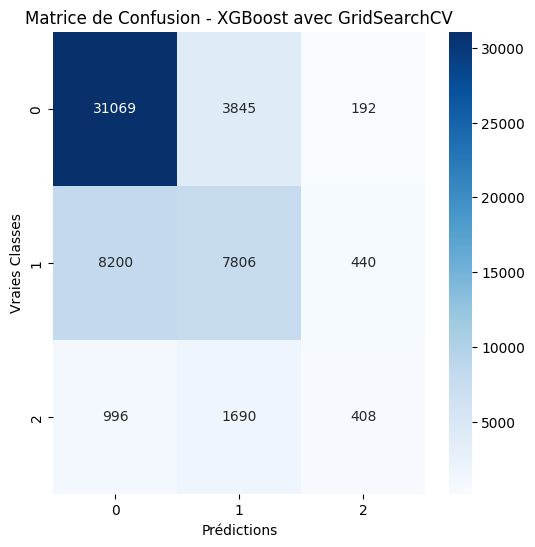


Rapport de Classification :
              precision    recall  f1-score   support

       léger       0.77      0.89      0.82     35106
 hospitalisé       0.59      0.47      0.52     16446
         tué       0.39      0.13      0.20      3094

    accuracy                           0.72     54646
   macro avg       0.58      0.50      0.52     54646
weighted avg       0.69      0.72      0.70     54646



In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBClassifier

# ==========================
# 1️⃣ Transformation des Données
# ==========================
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]  # Retourne un array 2D avec sin et cos


# Séparation des features et du target
X = df.drop(['lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué', 'blessé_léger',
             'indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']

# Décalage des labels (classes 2,3,4 deviennent 0,1,2)
y = y - 2

# Séparation en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Variables catégorielles et cycliques
categorical_features = ['agg', 'atm']
cyclical_features = ['heure']
passthrough_features = ['nbv', 'vma', 'nationale_departementale_communale', 'autoroute', 'autre_route',
                        'sens_unique', 'bidirectionnel', 'route_seche', 'route_mouillee_enneigee', 'etat_route_autre',
                        'usager_count', 'total_sans_secu', 'total_ceinture', 'total_casque', 'total_secu_enfant',
                        'total_gilet', 'total_airbag', 'total_gants', 'total_gants_airbag', 'total_autre',
                        'place_conducteur', 'pax_AV', 'pax_AR', 'pax_Milieu', 'place_pieton', 'homme', 'femme',
                        '0-17', '18-60', '61-95', 'obstacle_fixe', 'obstacle_mobile', 'aucun_choc', 'choc_AV',
                        'choc_AR', 'choc_cote', 'choc_tonneaux', 'VL_VU', '2roues_3roues_quad', 'PL', 'bus_car',
                        'velo_trott_edp', 'nbr_veh']

# Transformation des données
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cyclical', CyclicalFeatures(), cyclical_features)
], remainder='passthrough')

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# ==========================
# 2️⃣ Équilibrage des Classes avec SMOTE
# ==========================
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_transformed, y_train)

# ==========================
# 3️⃣ Définition de la Métrique Personnalisée (F1-score pour une classe cible)
# ==========================
def f1_xgb(preds, dtrain, target_class=1):
    labels = dtrain.get_label()
    preds = np.argmax(preds.reshape(len(labels), -1), axis=1)
    f1 = f1_score(labels == target_class, preds == target_class)
    return f'f1_class_{target_class}', f1

# Fonction pour GridSearchCV
def f1_class_specific(y_true, y_pred, target_class=1):
    y_pred = (y_pred == target_class).astype(int)
    y_true = (y_true == target_class).astype(int)
    return f1_score(y_true, y_pred)

f1_scorer = make_scorer(f1_class_specific, greater_is_better=True, target_class=1)

# ==========================
# 4️⃣ Entraînement du Modèle XGBoost avec GridSearchCV
# ==========================
xgb_model = XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    eval_metric="mlogloss",
    use_label_encoder=False
)

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}

grid_search = GridSearchCV(
    xgb_model, param_grid, scoring=f1_scorer,
    cv=3, n_jobs=-1, verbose=1
)

grid_search.fit(X_train_balanced, y_train_balanced)

# Meilleurs hyperparamètres
best_params = grid_search.best_params_
print("Meilleurs hyperparamètres :", best_params)

# ==========================
# 5️⃣ Évaluation sur l'Ensemble de Test
# ==========================
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_transformed)

# Calcul du F1-score pour la classe cible
f1_test = f1_score(y_test == 1, y_pred == 1)
print(f"F1-score de la classe cible (accidents graves) sur test : {f1_test:.4f}")

# ==========================
# 6️⃣ Matrice de Confusion et Rapport de Classification
# ==========================
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel("Prédictions")
plt.ylabel("Vraies Classes")
plt.title("Matrice de Confusion - XGBoost avec GridSearchCV")
plt.show()

# Rapport de classification
print("\nRapport de Classification :")
print(classification_report(y_test, y_pred, target_names=["léger", "hospitalisé", "tué"]))



